In [105]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import time


In [8]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '0MRK78HITOVG9ZE1'

    # American Airlines stock market prices
    ticker = "ALL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

File already exists. Loading data from CSV


In [9]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()
df.tail()

,Unnamed: 0,Date,Low,High,Close,Open
4,5680,2022-05-27,132.720,136.910,136.89,133.64
3,5681,2022-05-31,133.820,137.500,136.69,135.20
2,5682,2022-06-01,133.195,137.545,134.70,137.32
1,5683,2022-06-02,132.630,134.250,134.15,134.19
0,5684,2022-06-03,131.880,134.020,131.97,133.45


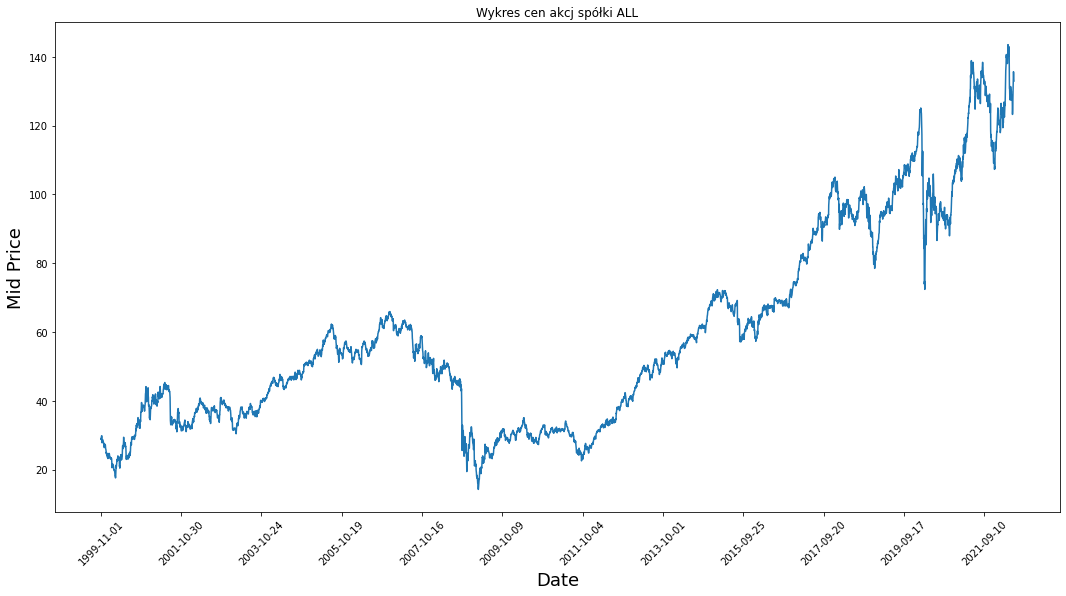

In [10]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.title("Wykres cen akcj spółki ALL")
plt.show()

In [11]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [12]:
split_index = 4536
train_data = mid_prices[:split_index]
test_data = mid_prices[split_index:]

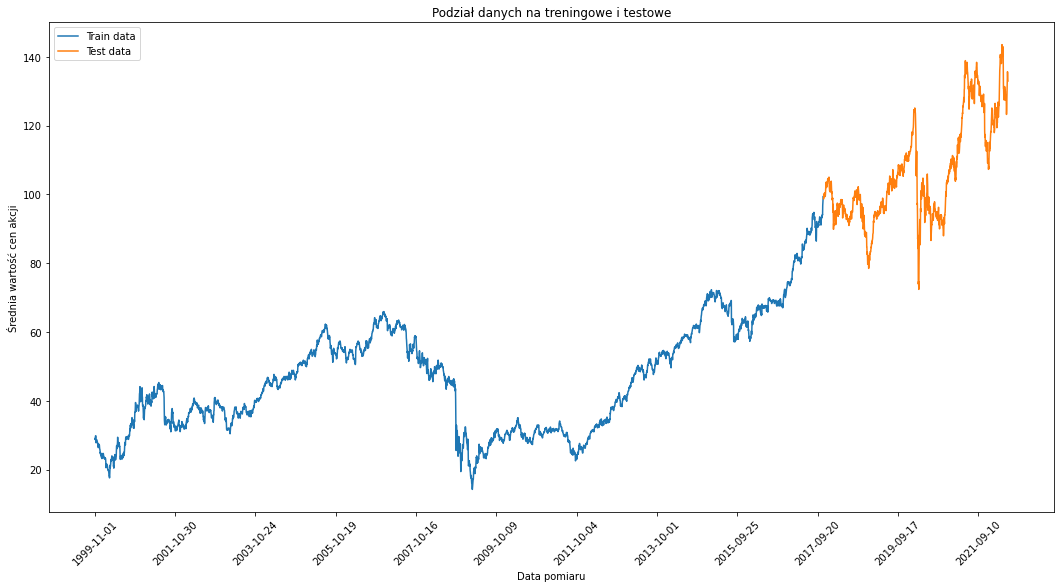

In [14]:
plt.figure(figsize = (18,9))
plt.plot(mid_prices[:4536], label = "Train data")
plt.plot(range(split_index, df.shape[0]) ,mid_prices[4536:], label = "Test data")
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.title("Podział danych na treningowe i testowe")
plt.xlabel("Data pomiaru")
plt.ylabel("Średnia wartość cen akcji")
plt.legend()
plt.show()

Normalizacja danych

In [15]:
scaler = MinMaxScaler() # normalization of data
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [16]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 500
for di in range(0,4000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [17]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

Wygładzanie danych - jednakże nie jest to wykorzystywane

In [18]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
train_data_smooth = train_data.copy()
test_data_smooth = test_data.copy()
for ti in range(split_index):
  EMA = gamma*train_data_smooth[ti] + (1-gamma)*EMA
  train_data_smooth[ti] = EMA

EMA = 0.0
gamma = 0.1

for ti in range(0, df.shape[0]-split_index):
  EMA = gamma*test_data_smooth[ti] + (1-gamma)*EMA
  test_data_smooth[ti] = EMA


# Used for visualization and test purposes
all_mid_data_smooth = np.concatenate([train_data_smooth,test_data_smooth],axis=0)

In [22]:

all_mid_data = np.concatenate([train_data,test_data],axis=0)

Wyznaczanie predykcji kolejnej wartości oraz błędu średnio-kwadratowego za pomocą własnej implementacji

In [43]:
window_size = 100
N = all_mid_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(all_mid_data[pred_idx-window_size:pred_idx])) # prediction of next step

    mse_errors.append((std_avg_predictions[-1]-all_mid_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%((1/(N-window_size))*np.sum(mse_errors)))

MSE error for standard averaging: 0.03923


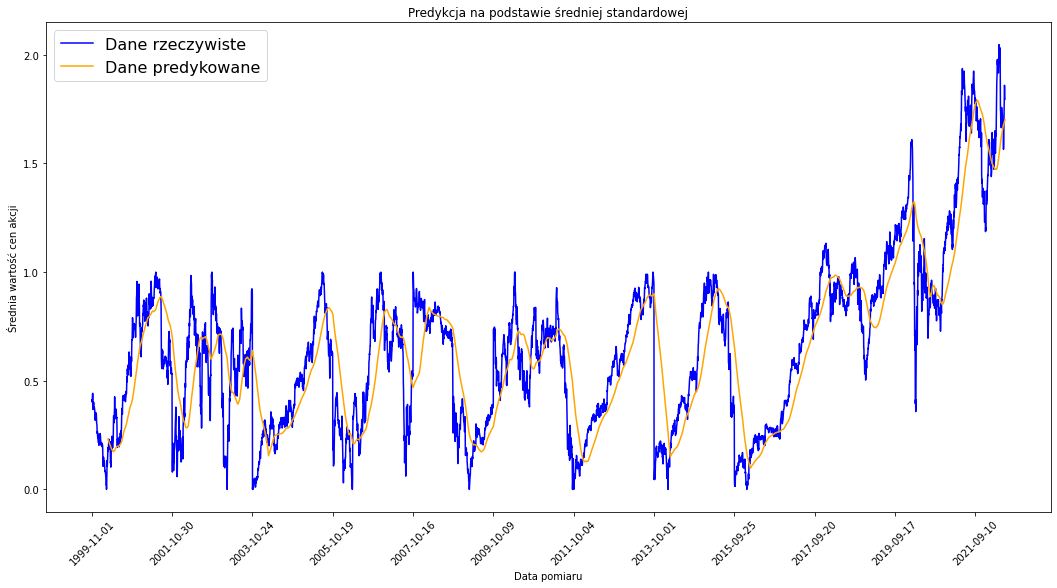

In [44]:
plt.figure(figsize = (18,9))
plt.plot(range(len(all_mid_data)), all_mid_data,color='b',label='Dane rzeczywiste')
plt.plot(range(100, len(all_mid_data)),std_avg_predictions,color='orange',label='Dane predykowane')
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Data pomiaru')
plt.ylabel('Średnia wartość cen akcji')
plt.title("Predykcja na podstawie średniej standardowej")
plt.legend(fontsize=16)
plt.show()


Predykcja za pomocą średniej kroczącej oraz wyliczanie błędu średnio-kwadratowego

In [87]:
window_size = 100
N = all_mid_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N, 30):

    running_mean = running_mean*decay + (1.0-decay)*all_mid_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-all_mid_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%((1/(N-window_size))*np.sum(mse_errors)))

MSE error for EMA averaging: 0.00042


Zrobić porównania 1 dniowej i 30 dniowej

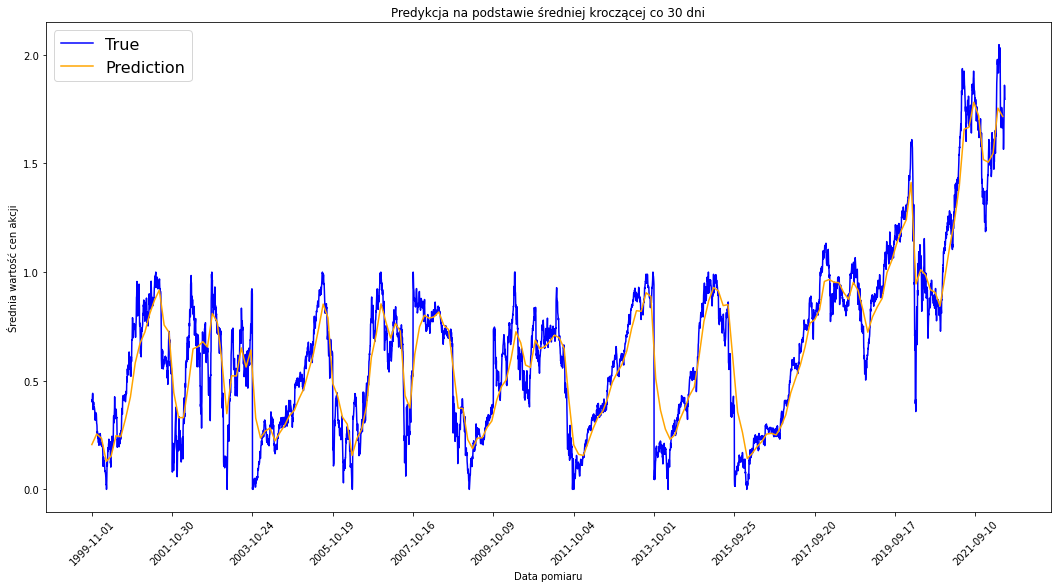

In [90]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N, 30),run_avg_predictions[1:],color='orange', label='Prediction')
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Data pomiaru')
plt.ylabel('Średnia wartość cen akcji')
plt.title("Predykcja na podstawie średniej kroczącej co 30 dni")
plt.legend(fontsize=16)
plt.show()

LSTM <br>
Normalizacja danych


In [94]:
scaler=MinMaxScaler(feature_range=(0,1))
normalized_data=scaler.fit_transform(np.array(all_mid_data).reshape(-1,1))

In [95]:
print(normalized_data)

[[0.20150813]
 [0.19657395]
 [0.19930537]
 ...
 [0.90530923]
 [0.88293015]
 [0.87724842]]


In [96]:
##splitting dataset into train and test split
training_size=int(len(normalized_data)*0.65)
test_size=len(normalized_data)-training_size
train_data,test_data=normalized_data[0:training_size,:],normalized_data[training_size:len(normalized_data),:1]

In [97]:
training_size,test_size

(3695, 1990)

In [98]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [99]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)


In [100]:
print(X_train.shape), print(y_train.shape)

(3594, 100)
(3594,)


(None, None)

In [101]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [102]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
st =time.time()
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)
end= time.time()

57/57 [==============================] - 9s 160ms/step - loss: 0.0013 - val_loss: 9.2151e-04
Epoch 7/100
22/57 [==========>...................] - ETA: 4s - loss: 8.9341e-04

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
### Calculate MSE performance metrics
import math
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train,train_predict)

In [ ]:
### Test Data MSE
math.sqrt(mean_squared_error(ytest,test_predict))

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Plotting
# shift train predictions for plotting
look_back=100
plt.figure(figsize = (18,9))
trainPredictPlot = np.empty_like(normalized_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(normalized_data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_data), color='blue',label='True')
plt.plot(trainPredictPlot, color='orange', label='Prediction LSTM')
plt.plot(testPredictPlot, color='green', label='Test')
plt.legend(fontsize=18)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.show()

In [36]:
len(test_data)

1990

In [37]:
x_input=test_data[1890:].reshape(1,-1)
x_input.shape

(1, 100)

In [38]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [39]:
temp_input

[0.8432777374909355,
 0.8440899202320522,
 0.8539521392313272,
 0.8449021029731689,
 0.8388300700991056,
 0.8338022721779068,
 0.8267246797196035,
 0.8192990089436791,
 0.8187962291515591,
 0.8234411409233744,
 0.8239980662315689,
 0.8296253323664491,
 0.8150060430263477,
 0.8150833937635968,
 0.8020884699057289,
 0.8061107082426879,
 0.8090887116267826,
 0.8322359197486102,
 0.8496591733139955,
 0.8679912980420594,
 0.8635436306502295,
 0.852289098380469,
 0.843163645153493,
 0.8543002175489485,
 0.8550930626057531,
 0.8497365240512449,
 0.8350398839738942,
 0.8510901619531062,
 0.8579357021996616,
 0.8535847232293934,
 0.8131496253323665,
 0.8373023930384336,
 0.8330287648054147,
 0.8242494561276288,
 0.8396422528402225,
 0.8519023446942229,
 0.8603335750543872,
 0.8707565868987188,
 0.8499299008943679,
 0.8395262267343486,
 0.8371357021996617,
 0.8485182499395698,
 0.8628861493836113,
 0.866057529610829,
 0.8631955523326083,
 0.8854377568286198,
 0.9102634759487553,
 0.9218660865361

In [40]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.9103706]
101
1 day input [0.84408992 0.85395214 0.8449021  0.83883007 0.83380227 0.82672468
 0.81929901 0.81879623 0.82344114 0.82399807 0.82962533 0.81500604
 0.81508339 0.80208847 0.80611071 0.80908871 0.83223592 0.84965917
 0.8679913  0.86354363 0.8522891  0.84316365 0.85430022 0.85509306
 0.84973652 0.83503988 0.85109016 0.8579357  0.85358472 0.81314963
 0.83730239 0.83302876 0.82424946 0.83964225 0.85190234 0.86033358
 0.87075659 0.8499299  0.83952623 0.8371357  0.84851825 0.86288615
 0.86605753 0.86319555 0.88543776 0.91026348 0.92186609 0.94201595
 0.94913222 0.95532028 0.97485134 0.97782934 0.96986222 0.97581823
 0.97284022 0.96626541 0.95856901 0.95740875 0.95876239 0.96959149
 0.98372734 1.         0.99341823 0.98769156 0.97864153 0.97372976
 0.97581823 0.99523326 0.99384095 0.94159052 0.90146483 0.90071066
 0.88539521 0.89479333 0.88005801 0.87533962 0.89680445 0.90531303
 0.90573846 0.90094271 0.88732898 0.89711385 0.89552816 0.87530094
 0.87982596 0.8791298  0.88195311 

In [41]:
day_new=np.arange(1,101)
day_pred=np.arange(101,108)

In [42]:
len(normalized_data)

5685

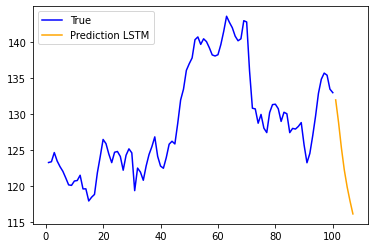

In [43]:
plt.plot(day_new,scaler.inverse_transform(normalized_data[5585:]), color='blue',label='True')
plt.plot(day_pred,scaler.inverse_transform(lst_output), color='orange', label='Prediction LSTM')
plt.legend()
plt.show()

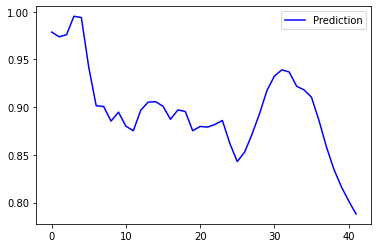

In [44]:
df3=normalized_data.tolist()
df3.extend(lst_output)
plt.plot(df3[5650:], color='blue',label='Prediction')
plt.legend()
plt.show()

In [45]:
df3=scaler.inverse_transform(df3).tolist()

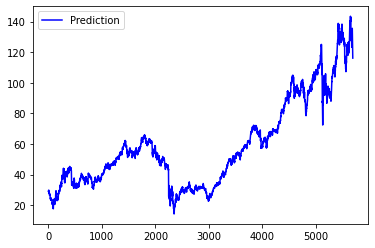

In [46]:
plt.plot(df3, color='blue',label='Prediction')
plt.legend()
plt.show()

In [47]:
len(test_data)

1990

In [48]:
x_input=test_data[1890:].reshape(1,-1)
x_input.shape

(1, 100)

In [49]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [50]:
temp_input

[0.8432777374909355,
 0.8440899202320522,
 0.8539521392313272,
 0.8449021029731689,
 0.8388300700991056,
 0.8338022721779068,
 0.8267246797196035,
 0.8192990089436791,
 0.8187962291515591,
 0.8234411409233744,
 0.8239980662315689,
 0.8296253323664491,
 0.8150060430263477,
 0.8150833937635968,
 0.8020884699057289,
 0.8061107082426879,
 0.8090887116267826,
 0.8322359197486102,
 0.8496591733139955,
 0.8679912980420594,
 0.8635436306502295,
 0.852289098380469,
 0.843163645153493,
 0.8543002175489485,
 0.8550930626057531,
 0.8497365240512449,
 0.8350398839738942,
 0.8510901619531062,
 0.8579357021996616,
 0.8535847232293934,
 0.8131496253323665,
 0.8373023930384336,
 0.8330287648054147,
 0.8242494561276288,
 0.8396422528402225,
 0.8519023446942229,
 0.8603335750543872,
 0.8707565868987188,
 0.8499299008943679,
 0.8395262267343486,
 0.8371357021996617,
 0.8485182499395698,
 0.8628861493836113,
 0.866057529610829,
 0.8631955523326083,
 0.8854377568286198,
 0.9102634759487553,
 0.9218660865361

In [51]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.9103706]
101
1 day input [0.84408992 0.85395214 0.8449021  0.83883007 0.83380227 0.82672468
 0.81929901 0.81879623 0.82344114 0.82399807 0.82962533 0.81500604
 0.81508339 0.80208847 0.80611071 0.80908871 0.83223592 0.84965917
 0.8679913  0.86354363 0.8522891  0.84316365 0.85430022 0.85509306
 0.84973652 0.83503988 0.85109016 0.8579357  0.85358472 0.81314963
 0.83730239 0.83302876 0.82424946 0.83964225 0.85190234 0.86033358
 0.87075659 0.8499299  0.83952623 0.8371357  0.84851825 0.86288615
 0.86605753 0.86319555 0.88543776 0.91026348 0.92186609 0.94201595
 0.94913222 0.95532028 0.97485134 0.97782934 0.96986222 0.97581823
 0.97284022 0.96626541 0.95856901 0.95740875 0.95876239 0.96959149
 0.98372734 1.         0.99341823 0.98769156 0.97864153 0.97372976
 0.97581823 0.99523326 0.99384095 0.94159052 0.90146483 0.90071066
 0.88539521 0.89479333 0.88005801 0.87533962 0.89680445 0.90531303
 0.90573846 0.90094271 0.88732898 0.89711385 0.89552816 0.87530094
 0.87982596 0.8791298  0.88195311 

In [52]:
day_new=np.arange(1,101)
day_pred=np.arange(101,108)

In [53]:
len(normalized_data)

5685

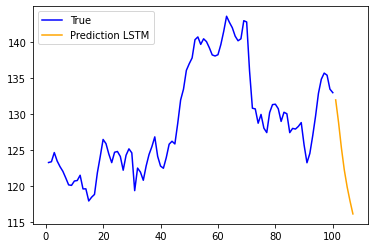

In [54]:
plt.plot(day_new,scaler.inverse_transform(normalized_data[5585:]), color='blue',label='True')
plt.plot(day_pred,scaler.inverse_transform(lst_output), color='orange', label='Prediction LSTM')
plt.legend()
plt.show()

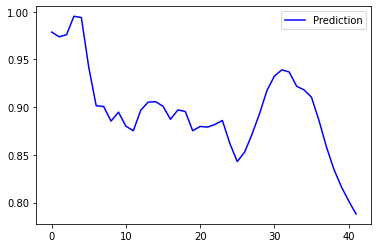

In [55]:
df3=normalized_data.tolist()
df3.extend(lst_output)
plt.plot(df3[5650:], color='blue',label='Prediction')
plt.legend()
plt.show()

In [56]:
df3=scaler.inverse_transform(df3).tolist()

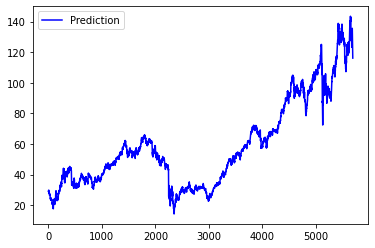

In [57]:
plt.plot(df3, color='blue',label='Prediction')
plt.legend()
plt.show()